# Role with Claude

In [ ]:
#  Mars Impact Crater vs Volcanic Depression Classification
# CNN-based classifier using TensorFlow/Keras for satellite imagery analysis
# Author: Planetary Geologist & ML Researcher

import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from google.colab import drive
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.19.0


In [ ]:
# ============================================================================
# 1. MOUNT GOOGLE DRIVE AND SET PATHS
# ============================================================================

def mount_drive_and_setup_paths():
    """
    Mount Google Drive and define dataset paths
    """
    # Mount Google Drive
    drive.mount('/content/drive')

    # Define paths to dataset
    base_path = '/content/drive/MyDrive/Dissertation/FinalDataset'
    train_path = os.path.join(base_path, 'train')
    val_path = os.path.join(base_path, 'val')
    test_path = os.path.join(base_path, 'test')

    # Verify paths exist
    for path in [train_path, val_path, test_path]:
        if not os.path.exists(path):
            print(f"WARNING: Path does not exist: {path}")
        else:
            print(f"✓ Found: {path}")
            # Count images in each class
            impact_count = len(os.listdir(os.path.join(path, 'Impact'))) if os.path.exists(os.path.join(path, 'Impact')) else 0
            volcanic_count = len(os.listdir(os.path.join(path, 'Volcanic'))) if os.path.exists(os.path.join(path, 'Volcanic')) else 0
            print(f"  Impact craters: {impact_count}, Volcanic depressions: {volcanic_count}")

    return train_path, val_path, test_path

In [ ]:
# ============================================================================
# 2. DATA LOADING AND PREPROCESSING
# ============================================================================

def create_data_generators(train_path, val_path, test_path, batch_size=32, target_size=(128, 128)):
    """
    Create data generators with appropriate augmentation for geological features

    Args:
        train_path, val_path, test_path: Paths to respective datasets
        batch_size: Batch size for training
        target_size: Input image dimensions

    Returns:
        train_generator, val_generator, test_generator
    """

    # Training data augmentation - geological considerations:
    # - Rotation: Craters can be viewed from any angle
    # - Zoom: Simulates different satellite altitudes
    # - Horizontal flip: Geological features can appear mirrored
    # - Avoid vertical flip: Lighting conditions on Mars are consistent
    # - Brightness: Simulates different lighting conditions and seasons

    train_datagen = ImageDataGenerator(
        rescale=1./255,                    # Normalize pixel values
        rotation_range=20,                 # Rotate up to 20 degrees
        width_shift_range=0.1,             # Horizontal translation
        height_shift_range=0.1,            # Vertical translation
        shear_range=0.1,                   # Shear transformation
        zoom_range=0.2,                    # Zoom in/out
        horizontal_flip=True,              # Mirror horizontally
        brightness_range=[0.8, 1.2],      # Brightness variation
        fill_mode='nearest'                # Fill missing pixels
    )

    # Validation and test data - only rescaling (no augmentation)
    val_test_datagen = ImageDataGenerator(rescale=1./255)

    # Create generators
    train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='binary',               # Binary classification
        color_mode='grayscale',            # Grayscale satellite imagery
        shuffle=True,
        seed=42
    )

    val_generator = val_test_datagen.flow_from_directory(
        val_path,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='binary',
        color_mode='grayscale',
        shuffle=False,                     # Don't shuffle validation data
        seed=42
    )

    test_generator = val_test_datagen.flow_from_directory(
        test_path,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='binary',
        color_mode='grayscale',
        shuffle=False,                     # Don't shuffle test data
        seed=42
    )

    print(f"Training samples: {train_generator.samples}")
    print(f"Validation samples: {val_generator.samples}")
    print(f"Test samples: {test_generator.samples}")
    print(f"Class indices: {train_generator.class_indices}")

    return train_generator, val_generator, test_generator


In [ ]:

# ============================================================================
# 3. CNN MODEL ARCHITECTURE
# ============================================================================

def build_crater_cnn(input_shape=(128, 128, 1), num_classes=1):
    """
    Build CNN architecture optimized for crater morphology recognition

    Geological considerations:
    - Multiple conv layers to detect hierarchical features
    - Small kernels (3x3) to capture fine rim details
    - Pooling to handle scale variations
    - Dropout to prevent overfitting on limited geological samples
    - BatchNormalization for stable training

    Args:
        input_shape: Input image dimensions (height, width, channels)
        num_classes: 1 for binary classification

    Returns:
        Compiled Keras model
    """

    model = Sequential([
        # First Convolutional Block - Edge Detection
        # Detects basic edges and textures (crater rims, slopes)
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, name='conv1_edges'),
        BatchNormalization(),
        Conv2D(32, (3, 3), activation='relu', name='conv1_detail'),
        MaxPooling2D((2, 2), name='pool1'),

        # Second Convolutional Block - Shape Recognition
        # Recognizes circular vs elliptical patterns
        Conv2D(64, (3, 3), activation='relu', name='conv2_shapes'),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu', name='conv2_patterns'),
        MaxPooling2D((2, 2), name='pool2'),

        # Third Convolutional Block - Complex Features
        # Combines features to distinguish rim characteristics
        Conv2D(128, (3, 3), activation='relu', name='conv3_complex'),
        BatchNormalization(),
        Conv2D(128, (3, 3), activation='relu', name='conv3_features'),
        MaxPooling2D((2, 2), name='pool3'),

        # Fourth Convolutional Block - High-level Morphology
        # Captures overall crater morphology
        Conv2D(256, (3, 3), activation='relu', name='conv4_morphology'),
        BatchNormalization(),
        Dropout(0.3),  # Prevent overfitting

        # Flatten and Dense Layers
        Flatten(name='flatten'),

        # Dense layer for feature combination
        Dense(512, activation='relu', name='dense1_features'),
        BatchNormalization(),
        Dropout(0.5),

        Dense(128, activation='relu', name='dense2_classification'),
        Dropout(0.3),

        # Output layer - Binary classification
        # Sigmoid activation for probability output (0=Impact, 1=Volcanic)
        Dense(num_classes, activation='sigmoid', name='output_probability')
    ])

    return model

def compile_model(model, learning_rate=0.001):
    """
    Compile the model with appropriate loss function and optimizer

    Args:
        model: Keras model to compile
        learning_rate: Learning rate for Adam optimizer

    Returns:
        Compiled model
    """

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',        # Binary classification loss
        metrics=['accuracy', 'precision', 'recall']
    )

    return model


In [ ]:

# ============================================================================
# 4. TRAINING SETUP AND CALLBACKS
# ============================================================================

def setup_callbacks(patience=10, min_delta=0.001):
    """
    Setup training callbacks for optimal model performance

    Args:
        patience: Number of epochs to wait before early stopping
        min_delta: Minimum change to qualify as improvement

    Returns:
        List of callbacks
    """

    callbacks = [
        # Early stopping to prevent overfitting
        EarlyStopping(
            monitor='val_loss',
            patience=patience,
            min_delta=min_delta,
            restore_best_weights=True,
            verbose=1
        ),

        # Save best model weights
        ModelCheckpoint(
            'best_crater_model.h5',
            monitor='val_accuracy',
            save_best_only=True,
            save_weights_only=False,
            verbose=1
        ),

        # Reduce learning rate on plateau
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-7,
            verbose=1
        )
    ]

    return callbacks

In [ ]:

# ============================================================================
# 5. TRAINING FUNCTION
# ============================================================================

def train_model(model, train_gen, val_gen, epochs=50, callbacks=None):
    """
    Train the crater classification model

    Args:
        model: Compiled Keras model
        train_gen: Training data generator
        val_gen: Validation data generator
        epochs: Maximum number of training epochs
        callbacks: List of training callbacks

    Returns:
        Training history
    """

    print("Starting model training...")
    print("=" * 60)

    # Calculate steps per epoch
    steps_per_epoch = train_gen.samples // train_gen.batch_size
    validation_steps = val_gen.samples // val_gen.batch_size

    # Train the model
    history = model.fit(
        train_gen,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_data=val_gen,
        validation_steps=validation_steps,
        callbacks=callbacks,
        verbose=1
    )

    print("Training completed!")
    return history


In [ ]:
# ============================================================================
# 6. EVALUATION AND VISUALIZATION
# ============================================================================

def plot_training_history(history):
    """
    Plot training and validation metrics
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Accuracy
    axes[0, 0].plot(history.history['accuracy'], label='Training Accuracy')
    axes[0, 0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axes[0, 0].set_title('Model Accuracy')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].legend()
    axes[0, 0].grid(True)

    # Loss
    axes[0, 1].plot(history.history['loss'], label='Training Loss')
    axes[0, 1].plot(history.history['val_loss'], label='Validation Loss')
    axes[0, 1].set_title('Model Loss')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True)

    # Precision
    axes[1, 0].plot(history.history['precision'], label='Training Precision')
    axes[1, 0].plot(history.history['val_precision'], label='Validation Precision')
    axes[1, 0].set_title('Model Precision')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Precision')
    axes[1, 0].legend()
    axes[1, 0].grid(True)

    # Recall
    axes[1, 1].plot(history.history['recall'], label='Training Recall')
    axes[1, 1].plot(history.history['val_recall'], label='Validation Recall')
    axes[1, 1].set_title('Model Recall')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Recall')
    axes[1, 1].legend()
    axes[1, 1].grid(True)

    plt.tight_layout()
    plt.show()

def evaluate_model(model, test_gen):
    """
    Evaluate model on test set and generate detailed metrics
    """
    print("Evaluating model on test set...")
    print("=" * 40)

    # Get test predictions
    test_gen.reset()
    predictions = model.predict(test_gen, verbose=1)
    predicted_classes = (predictions > 0.5).astype(int).flatten()
    true_classes = test_gen.classes

    # Get class names
    class_names = list(test_gen.class_indices.keys())

    # Print classification report
    print("\nClassification Report:")
    print("=" * 40)
    print(classification_report(true_classes, predicted_classes, target_names=class_names))

    # Create confusion matrix
    cm = confusion_matrix(true_classes, predicted_classes)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix - Mars Crater Classification')
    plt.xlabel('Predicted Class')
    plt.ylabel('True Class')
    plt.show()

    # Calculate additional metrics
    test_loss, test_accuracy, test_precision, test_recall = model.evaluate(test_gen, verbose=0)

    print(f"\nFinal Test Metrics:")
    print("=" * 20)
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Test Precision: {test_precision:.4f}")
    print(f"Test Recall: {test_recall:.4f}")
    print(f"Test Loss: {test_loss:.4f}")

Mars Impact Crater vs Volcanic Depression Classification
Geological Context:
• Impact craters: Circular, sharp raised rims, bowl-shaped
• Volcanic depressions: Elliptical, flat/collapsed rims, complex floors
Mounted at /content/drive
✓ Found: /content/drive/MyDrive/Dissertation/FinalDataset/train
  Impact craters: 1200, Volcanic depressions: 1200
✓ Found: /content/drive/MyDrive/Dissertation/FinalDataset/val
  Impact craters: 150, Volcanic depressions: 150
✓ Found: /content/drive/MyDrive/Dissertation/FinalDataset/test
  Impact craters: 150, Volcanic depressions: 150
Found 2400 images belonging to 2 classes.
Found 300 images belonging to 2 classes.
Found 300 images belonging to 2 classes.
Training samples: 2400
Validation samples: 300
Test samples: 300
Class indices: {'Impact': 0, 'Volcanic': 1}

Building CNN architecture...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1_edges (Conv2D)            │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_detail (Conv2D)           │ (None, 124, 124, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2_shapes (Conv2D)           │ (None, 60, 60, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 60, 60, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2_patterns (Conv2D)         │ (None, 58, 58, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 29, 29, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3_complex (Conv2D)          │ (None, 27, 27, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 27, 27, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3_features (Conv2D)         │ (None, 25, 25, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool3 (MaxPooling2D)            │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv4_morphology (Conv2D)       │ (None, 10, 10, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 10, 10, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 10, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1_features (Dense)         │ (None, 512)            │    13,107,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense2_classification (Dense)   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_probability (Dense)      │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 13,759,073 (52.49 MB)

 Trainable params: 13,757,089 (52.48 MB)

 Non-trainable params: 1,984 (7.75 KB)

Starting model training...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.6118 - loss: 0.9033 - precision: 0.6016 - recall: 0.6442
Epoch 1: val_accuracy improved from -inf to 0.53125, saving model to best_crater_model.h5


75/75 ━━━━━━━━━━━━━━━━━━━━ 507s 7s/step - accuracy: 0.6126 - loss: 0.9013 - precision: 0.6025 - recall: 0.6450 - val_accuracy: 0.5312 - val_loss: 0.7813 - val_precision: 0.7143 - val_recall: 0.0362 - learning_rate: 0.0010
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7913 - loss: 0.5223 - precision: 0.7809 - recall: 0.8302
Epoch 2: val_accuracy did not improve from 0.53125
75/75 ━━━━━━━━━━━━━━━━━━━━ 318s 4s/step - accuracy: 0.7915 - loss: 0.5218 - precision: 0.7809 - recall: 0.8304 - val_accuracy: 0.4792 - val_loss: 0.8745 - val_precision: 0.4792 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8033 - loss: 0.4751 - precision: 0.7944 - recall: 0.8253
Epoch 3: val_accuracy did not improve from 0.53125
75/75 ━━━━━━━━━━━━━━━━━━━━ 310s 4s/step - accuracy: 0.8034 - loss: 0.4748 - precision: 0.7944 - recall: 0.8255 - val_accuracy: 0.4792 - val_loss: 1.8254 - val_precision: 0.4792 - val_recall: 1.0000 - learning_rate:

75/75 ━━━━━━━━━━━━━━━━━━━━ 382s 5s/step - accuracy: 0.8969 - loss: 0.2779 - precision: 0.8673 - recall: 0.9411 - val_accuracy: 0.5590 - val_loss: 0.8943 - val_precision: 0.5208 - val_recall: 1.0000 - learning_rate: 5.0000e-04
Epoch 8/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9154 - loss: 0.2068 - precision: 0.8873 - recall: 0.9509
Epoch 8: val_accuracy improved from 0.55903 to 0.85069, saving model to best_crater_model.h5


75/75 ━━━━━━━━━━━━━━━━━━━━ 323s 4s/step - accuracy: 0.9155 - loss: 0.2068 - precision: 0.8875 - recall: 0.9508 - val_accuracy: 0.8507 - val_loss: 0.3228 - val_precision: 0.7684 - val_recall: 0.9855 - learning_rate: 5.0000e-04
Epoch 9/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9271 - loss: 0.2117 - precision: 0.9164 - recall: 0.9433
Epoch 9: val_accuracy improved from 0.85069 to 0.90278, saving model to best_crater_model.h5


75/75 ━━━━━━━━━━━━━━━━━━━━ 320s 4s/step - accuracy: 0.9272 - loss: 0.2114 - precision: 0.9164 - recall: 0.9435 - val_accuracy: 0.9028 - val_loss: 0.2534 - val_precision: 0.8354 - val_recall: 0.9928 - learning_rate: 5.0000e-04
Epoch 10/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9368 - loss: 0.1706 - precision: 0.9200 - recall: 0.9537
Epoch 10: val_accuracy did not improve from 0.90278
75/75 ━━━━━━━━━━━━━━━━━━━━ 298s 4s/step - accuracy: 0.9367 - loss: 0.1707 - precision: 0.9200 - recall: 0.9536 - val_accuracy: 0.8993 - val_loss: 0.2505 - val_precision: 0.8428 - val_recall: 0.9710 - learning_rate: 5.0000e-04
Epoch 11/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9427 - loss: 0.1514 - precision: 0.9204 - recall: 0.9650
Epoch 11: val_accuracy improved from 0.90278 to 0.92708, saving model to best_crater_model.h5


75/75 ━━━━━━━━━━━━━━━━━━━━ 313s 4s/step - accuracy: 0.9427 - loss: 0.1515 - precision: 0.9205 - recall: 0.9650 - val_accuracy: 0.9271 - val_loss: 0.1905 - val_precision: 0.8774 - val_recall: 0.9855 - learning_rate: 5.0000e-04
Epoch 12/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9430 - loss: 0.1634 - precision: 0.9243 - recall: 0.9620
Epoch 12: val_accuracy improved from 0.92708 to 0.93750, saving model to best_crater_model.h5


75/75 ━━━━━━━━━━━━━━━━━━━━ 296s 4s/step - accuracy: 0.9430 - loss: 0.1634 - precision: 0.9244 - recall: 0.9620 - val_accuracy: 0.9375 - val_loss: 0.1730 - val_precision: 0.8896 - val_recall: 0.9928 - learning_rate: 5.0000e-04
Epoch 13/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9448 - loss: 0.1527 - precision: 0.9325 - recall: 0.9578
Epoch 13: val_accuracy did not improve from 0.93750
75/75 ━━━━━━━━━━━━━━━━━━━━ 299s 4s/step - accuracy: 0.9447 - loss: 0.1529 - precision: 0.9324 - recall: 0.9577 - val_accuracy: 0.9306 - val_loss: 0.2169 - val_precision: 0.9683 - val_recall: 0.8841 - learning_rate: 5.0000e-04
Epoch 14/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9494 - loss: 0.1513 - precision: 0.9297 - recall: 0.9687
Epoch 14: val_accuracy improved from 0.93750 to 0.96528, saving model to best_crater_model.h5


75/75 ━━━━━━━━━━━━━━━━━━━━ 384s 5s/step - accuracy: 0.9493 - loss: 0.1513 - precision: 0.9297 - recall: 0.9686 - val_accuracy: 0.9653 - val_loss: 0.0992 - val_precision: 0.9384 - val_recall: 0.9928 - learning_rate: 5.0000e-04
Epoch 15/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9353 - loss: 0.1875 - precision: 0.9097 - recall: 0.9591
Epoch 15: val_accuracy did not improve from 0.96528
75/75 ━━━━━━━━━━━━━━━━━━━━ 320s 4s/step - accuracy: 0.9354 - loss: 0.1873 - precision: 0.9099 - recall: 0.9590 - val_accuracy: 0.8924 - val_loss: 0.3265 - val_precision: 0.9084 - val_recall: 0.8623 - learning_rate: 5.0000e-04
Epoch 16/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9314 - loss: 0.1909 - precision: 0.9088 - recall: 0.9590
Epoch 16: val_accuracy improved from 0.96528 to 0.96875, saving model to best_crater_model.h5


75/75 ━━━━━━━━━━━━━━━━━━━━ 326s 4s/step - accuracy: 0.9315 - loss: 0.1907 - precision: 0.9089 - recall: 0.9591 - val_accuracy: 0.9688 - val_loss: 0.0876 - val_precision: 0.9388 - val_recall: 1.0000 - learning_rate: 5.0000e-04
Epoch 17/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9508 - loss: 0.1353 - precision: 0.9448 - recall: 0.9542
Epoch 17: val_accuracy did not improve from 0.96875
75/75 ━━━━━━━━━━━━━━━━━━━━ 321s 4s/step - accuracy: 0.9509 - loss: 0.1355 - precision: 0.9449 - recall: 0.9543 - val_accuracy: 0.9444 - val_loss: 0.1282 - val_precision: 0.9357 - val_recall: 0.9493 - learning_rate: 5.0000e-04
Epoch 18/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9618 - loss: 0.1128 - precision: 0.9444 - recall: 0.9824
Epoch 18: val_accuracy did not improve from 0.96875
75/75 ━━━━━━━━━━━━━━━━━━━━ 323s 4s/step - accuracy: 0.9617 - loss: 0.1131 - precision: 0.9443 - recall: 0.9823 - val_accuracy: 0.9618 - val_loss: 0.1073 - val_precision: 0.9922 - val_recall: 0.9275 - le

75/75 ━━━━━━━━━━━━━━━━━━━━ 320s 4s/step - accuracy: 0.9534 - loss: 0.1388 - precision: 0.9312 - recall: 0.9770 - val_accuracy: 0.9722 - val_loss: 0.0966 - val_precision: 0.9851 - val_recall: 0.9565 - learning_rate: 5.0000e-04
Epoch 22/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9571 - loss: 0.1220 - precision: 0.9443 - recall: 0.9666
Epoch 22: val_accuracy did not improve from 0.97222
75/75 ━━━━━━━━━━━━━━━━━━━━ 382s 5s/step - accuracy: 0.9570 - loss: 0.1222 - precision: 0.9443 - recall: 0.9665 - val_accuracy: 0.9583 - val_loss: 0.1233 - val_precision: 0.9500 - val_recall: 0.9638 - learning_rate: 5.0000e-04
Epoch 23/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9621 - loss: 0.1143 - precision: 0.9493 - recall: 0.9749
Epoch 23: val_accuracy improved from 0.97222 to 0.97569, saving model to best_crater_model.h5


75/75 ━━━━━━━━━━━━━━━━━━━━ 323s 4s/step - accuracy: 0.9621 - loss: 0.1144 - precision: 0.9493 - recall: 0.9748 - val_accuracy: 0.9757 - val_loss: 0.0585 - val_precision: 0.9712 - val_recall: 0.9783 - learning_rate: 5.0000e-04
Epoch 24/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9526 - loss: 0.1374 - precision: 0.9358 - recall: 0.9672
Epoch 24: val_accuracy did not improve from 0.97569
75/75 ━━━━━━━━━━━━━━━━━━━━ 380s 4s/step - accuracy: 0.9525 - loss: 0.1376 - precision: 0.9358 - recall: 0.9671 - val_accuracy: 0.8194 - val_loss: 0.5869 - val_precision: 1.0000 - val_recall: 0.6232 - learning_rate: 5.0000e-04
Epoch 25/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9579 - loss: 0.1164 - precision: 0.9426 - recall: 0.9700
Epoch 25: val_accuracy did not improve from 0.97569
75/75 ━━━━━━━━━━━━━━━━━━━━ 321s 4s/step - accuracy: 0.9579 - loss: 0.1165 - precision: 0.9427 - recall: 0.9700 - val_accuracy: 0.9444 - val_loss: 0.1394 - val_precision: 1.0000 - val_recall: 0.8841 - le

75/75 ━━━━━━━━━━━━━━━━━━━━ 382s 4s/step - accuracy: 0.9716 - loss: 0.0942 - precision: 0.9576 - recall: 0.9867 - val_accuracy: 0.9896 - val_loss: 0.0473 - val_precision: 0.9927 - val_recall: 0.9855 - learning_rate: 2.5000e-04
Epoch 30/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9687 - loss: 0.0838 - precision: 0.9587 - recall: 0.9803
Epoch 30: val_accuracy did not improve from 0.98958
75/75 ━━━━━━━━━━━━━━━━━━━━ 321s 4s/step - accuracy: 0.9687 - loss: 0.0837 - precision: 0.9588 - recall: 0.9804 - val_accuracy: 0.9896 - val_loss: 0.0291 - val_precision: 1.0000 - val_recall: 0.9783 - learning_rate: 2.5000e-04
Epoch 31/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9755 - loss: 0.0814 - precision: 0.9690 - recall: 0.9826
Epoch 31: val_accuracy did not improve from 0.98958
75/75 ━━━━━━━━━━━━━━━━━━━━ 321s 4s/step - accuracy: 0.9755 - loss: 0.0816 - precision: 0.9689 - recall: 0.9825 - val_accuracy: 0.9722 - val_loss: 0.0820 - val_precision: 1.0000 - val_recall: 0.9420 - le

75/75 ━━━━━━━━━━━━━━━━━━━━ 383s 4s/step - accuracy: 0.9795 - loss: 0.0777 - precision: 0.9722 - recall: 0.9880 - val_accuracy: 0.9965 - val_loss: 0.0181 - val_precision: 1.0000 - val_recall: 0.9928 - learning_rate: 2.5000e-04
Epoch 35/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9748 - loss: 0.0675 - precision: 0.9611 - recall: 0.9874
Epoch 35: val_accuracy did not improve from 0.99653
75/75 ━━━━━━━━━━━━━━━━━━━━ 320s 4s/step - accuracy: 0.9749 - loss: 0.0675 - precision: 0.9612 - recall: 0.9874 - val_accuracy: 0.9826 - val_loss: 0.0354 - val_precision: 0.9854 - val_recall: 0.9783 - learning_rate: 2.5000e-04
Epoch 36/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9707 - loss: 0.0757 - precision: 0.9720 - recall: 0.9700
Epoch 36: val_accuracy did not improve from 0.99653
75/75 ━━━━━━━━━━━━━━━━━━━━ 309s 4s/step - accuracy: 0.9707 - loss: 0.0758 - precision: 0.9719 - recall: 0.9700 - val_accuracy: 0.9896 - val_loss: 0.0356 - val_precision: 1.0000 - val_recall: 0.9783 - le

75/75 ━━━━━━━━━━━━━━━━━━━━ 308s 4s/step - accuracy: 0.9708 - loss: 0.0830 - precision: 0.9663 - recall: 0.9765 - val_accuracy: 1.0000 - val_loss: 0.0118 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 1.2500e-04
Epoch 45/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9842 - loss: 0.0465 - precision: 0.9806 - recall: 0.9887
Epoch 45: val_accuracy did not improve from 1.00000
75/75 ━━━━━━━━━━━━━━━━━━━━ 320s 4s/step - accuracy: 0.9842 - loss: 0.0465 - precision: 0.9805 - recall: 0.9887 - val_accuracy: 1.0000 - val_loss: 0.0116 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 1.2500e-04
Epoch 46/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9829 - loss: 0.0421 - precision: 0.9769 - recall: 0.9873
Epoch 46: val_accuracy did not improve from 1.00000
75/75 ━━━━━━━━━━━━━━━━━━━━ 324s 4s/step - accuracy: 0.9830 - loss: 0.0421 - precision: 0.9769 - recall: 0.9873 - val_accuracy: 1.0000 - val_loss: 0.0072 - val_precision: 1.0000 - val_recall: 1.0000 - le

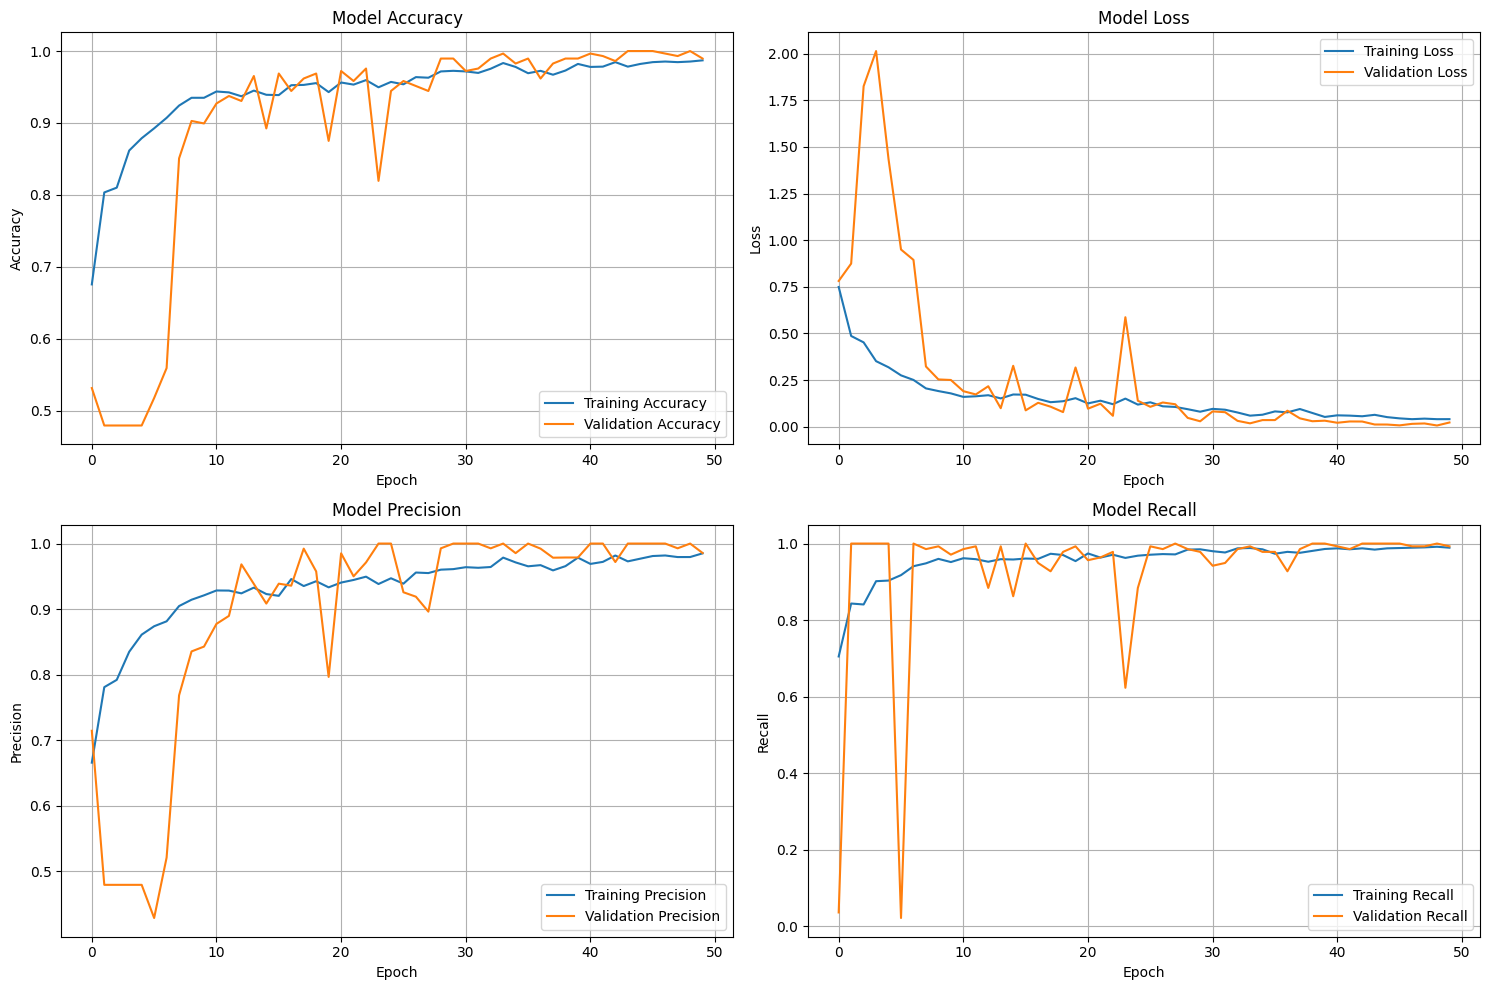

Evaluating model on test set...
10/10 ━━━━━━━━━━━━━━━━━━━━ 77s 8s/step

Classification Report:
              precision    recall  f1-score   support

      Impact       0.99      0.99      0.99       150
    Volcanic       0.99      0.99      0.99       150

    accuracy                           0.99       300
   macro avg       0.99      0.99      0.99       300
weighted avg       0.99      0.99      0.99       300



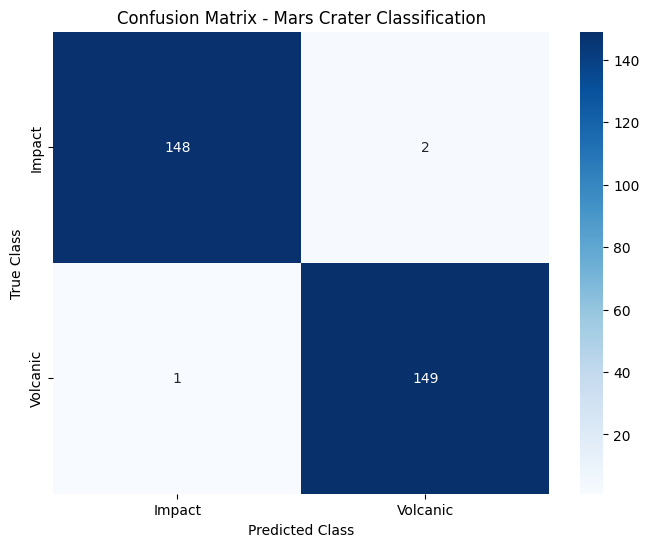


Final Test Metrics:
Test Accuracy: 0.9900
Test Precision: 0.9868
Test Recall: 0.9933
Test Loss: 0.0265

Model saved as /content/drive/MyDrive/Dissertation/Models/EXP_008.h5
Training history saved to /content/drive/MyDrive/Dissertation/Models/EXP_008_history.pkl

Classification pipeline completed successfully!
Model ready for Mars geological survey applications.


In [ ]:

# ============================================================================
# 7. MAIN EXECUTION PIPELINE
# ============================================================================
import pickle

def main(experiment_name="EXP_008"):
    """
    Main execution pipeline for Mars crater classification
    """
    print("Mars Impact Crater vs Volcanic Depression Classification")
    print("=" * 60)
    print("Geological Context:")
    print("• Impact craters: Circular, sharp raised rims, bowl-shaped")
    print("• Volcanic depressions: Elliptical, flat/collapsed rims, complex floors")
    print("=" * 60)

    # 1. Mount drive and setup paths
    train_path, val_path, test_path = mount_drive_and_setup_paths()

    # 2. Create data generators
    train_gen, val_gen, test_gen = create_data_generators(
        train_path, val_path, test_path,
        batch_size=32,
        target_size=(128, 128)
    )

    # 3. Build and compile model
    print("\nBuilding CNN architecture...")
    model = build_crater_cnn(input_shape=(128, 128, 1))
    model = compile_model(model, learning_rate=0.001)

    # Display model architecture
    model.summary()

    # 4. Setup callbacks
    callbacks = setup_callbacks(patience=10, min_delta=0.001)

    # 5. Train model
    history = train_model(
        model,
        train_gen,
        val_gen,
        epochs=50,
        callbacks=callbacks
    )

    # 6. Plot training history
    plot_training_history(history)

    # 7. Evaluate on test set
    evaluate_model(model, test_gen)

    # 8. Save final model
    save_dir = "/content/drive/MyDrive/Dissertation/Models"
    os.makedirs(save_dir, exist_ok=True)

    # Save model
    model_path = os.path.join(save_dir, f"{experiment_name}.h5")
    model.save(model_path)
    print(f"\nModel saved as {model_path}")

    # Save training history
    history_path = os.path.join(save_dir, f"{experiment_name}_history.pkl")
    with open(history_path, "wb") as f:
        pickle.dump(history.history, f)
        f.flush()
        os.fsync(f.fileno())  # Ensures Drive syncs it properly
    print(f"Training history saved to {history_path}")


    print("\n" + "=" * 60)
    print("Classification pipeline completed successfully!")
    print("Model ready for Mars geological survey applications.")

# Run the complete pipeline
if __name__ == "__main__":
    main()